audio signal:
    any object that vibrate produces sound wave.
    when an object vibrates, the air molecule oscillate to and for from their rest position and transmit its energy to neighboring molecues, this result in the transmission of enery from one molecule to another molecule which in turn produce a sound wave.
 
parameter of an audio signal:
    Amplitude: Amplitude refers to the maximum displacement of the air molecules from the rest position
    Crest and Trough: The crest is the highest point in the wave whereas trough is the lowest point
    Wavelength: The distance between 2 successive crests or troughs is known as a wavelength
    Cycle: Every audio signal traverses in the form of cycles. One complete upward movement and downward movement of the signal form a cycle
    Frequency: Frequency refers to how fast a signal is changing over a period of time
    
Type of signals:
    Digital and Analog.
    A digital signal is a discrete representation of a signal over a period of time. Here, the finite number of samples exists between any two-time intervals.
    Analog is a continuous representation of a signal over a period of time. In an analog signal, an infinite number of samples exist between any two-time intervals. Here, time can even be in picoseconds. 
    
    Sampling the signal is a process of converting an analog signal to a digital signal by selecting a certain number of samples per second from the analog signal.
    
    

Different Feature Extraction Techniques for an Audio Signal:
    Time-domain -  a plot between amplitude and time.  The features are the amplitudes which are recorded at different time intervals. The limitation of the time-domain analysis is that it completely ignores the information about the rate of the signal which is addressed by the frequency domain analysis.
    Frequency domain - a plot between frequency and amplitude. The features are the amplitudes recorded at different frequencies. The limitation of this frequency domain analysis is that it completely ignores the order or sequence of the signal which is addressed by time-domain analysis.
    Spectrogram -  It’s a 2D plot between time and frequency where each point in the plot represents the amplitude of a particular frequency at a particular time in terms of intensity of color. Is a spectrum (broad range of colors) of frequencies as it varies with time. 

In [1]:
import os
import librosa   #for audio processing
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile #for audio processing
import warnings
warnings.filterwarnings("ignore")

Data Exploration and Visualization:

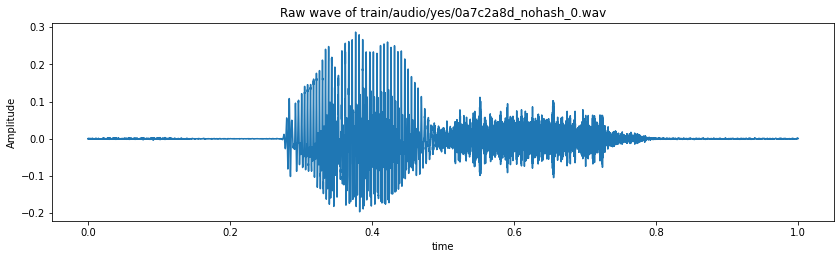

In [2]:
# Visualization of Audio signal in time series domain

train_audio_path = 'train/audio/'
samples, sample_rate = librosa.load(train_audio_path+'yes/0a7c2a8d_nohash_0.wav', sr = 16000)
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + 'train/audio/yes/0a7c2a8d_nohash_0.wav')
ax1.set_xlabel('time')
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, sample_rate/len(samples), sample_rate), samples)

In [3]:
# look at the sampling rate of audio signals:

ipd.Audio(samples, rate=sample_rate)
print(sample_rate)

16000


In [4]:
# re-sample it to 8000 Hz since most of the speech-related frequencies are present at 8000 Hz:

samples = librosa.resample(samples, sample_rate, 8000)
ipd.Audio(samples, rate=8000)

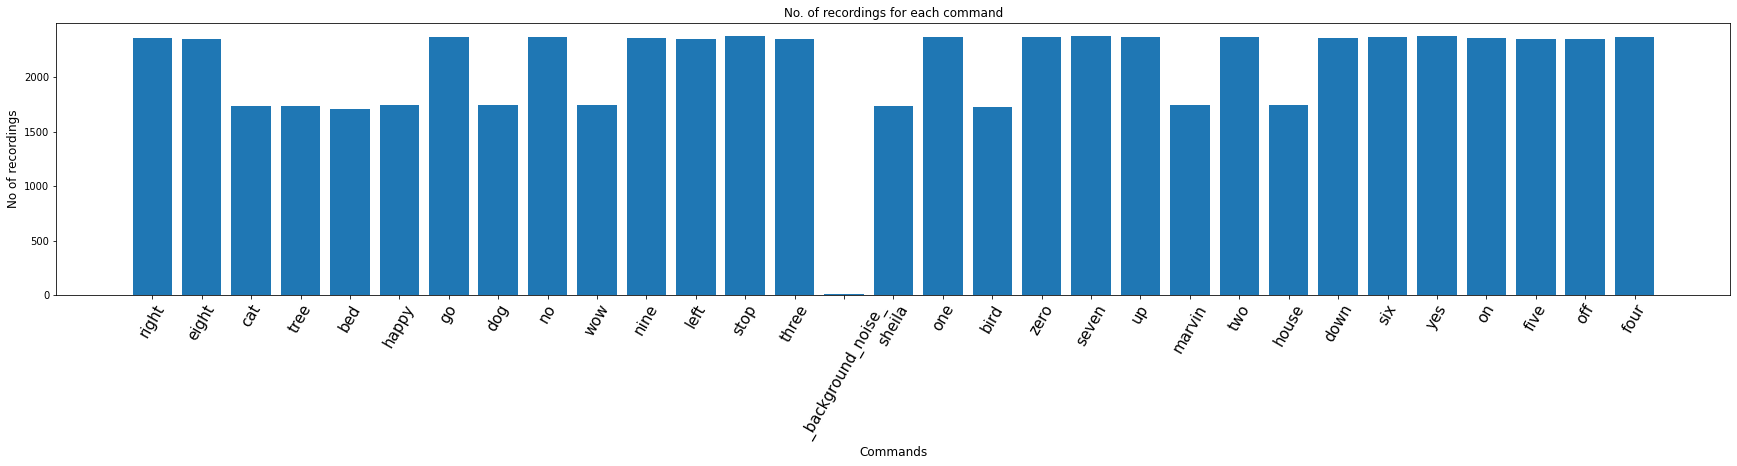

In [5]:
# understand the number of recordings for each voice command

labels=os.listdir(train_audio_path)

#find count of each label and plot bar graph
no_of_recordings=[]
for label in labels:
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    no_of_recordings.append(len(waves))
    
#plot
plt.figure(figsize=(30,5))
index = np.arange(len(labels))
plt.bar(index, no_of_recordings)
plt.xlabel('Commands', fontsize=12)
plt.ylabel('No of recordings', fontsize=12)
plt.xticks(index, labels, fontsize=15, rotation=60)
plt.title('No. of recordings for each command')
plt.show()

labels=["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go"]

(array([1.5000e+01, 3.0000e+01, 4.4000e+01, 1.3800e+02, 1.3600e+02,
        1.7900e+02, 3.6600e+02, 4.3400e+02, 5.9300e+02, 2.1747e+04]),
 array([0.418 , 0.4762, 0.5344, 0.5926, 0.6508, 0.709 , 0.7672, 0.8254,
        0.8836, 0.9418, 1.    ]),
 <BarContainer object of 10 artists>)

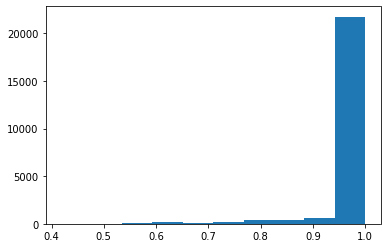

In [6]:
# Duration of recording:
duration_of_recordings=[]
for label in labels:
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        sample_rate, samples = wavfile.read(train_audio_path + '/' + label + '/' + wav)
        duration_of_recordings.append(float(len(samples)/sample_rate))
    
plt.hist(np.array(duration_of_recordings))

# preprocessing the audio waves

have seen that the duration of a few recordings is less than 1 second and the sampling rate is too high. So, let us read the audio waves and use the below-preprocessing steps to deal with this.
    Resampling
    Removing shorter commands of less than 1 second

In [7]:
# pre-processing
train_audio_path = 'train/audio/'

all_wave = []
all_label = []
for label in labels:
    print(label)
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        samples, sample_rate = librosa.load(train_audio_path + '/' + label + '/' + wav, sr = 16000)
        samples = librosa.resample(samples, sample_rate, 8000)
        if(len(samples)== 8000) : 
            all_wave.append(samples)
            all_label.append(label)

yes
no
up
down
left
right
on
off
stop
go


In [8]:
# convert the output labels to integer encoded

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y=le.fit_transform(all_label)
classes= list(le.classes_)

In [9]:
# convert the integer encoded labels to a one-hot vector it is a multi-classification problem

from keras.utils import np_utils
y=np_utils.to_categorical(y, num_classes=len(labels))

In [10]:
# reshape the 2D array to 3D since the input to the conv1d must be a 3D array

all_wave = np.array(all_wave).reshape(-1,8000,1)

In [11]:
# split into train and validation set, train 80%, validate on the remaining 20%

from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val = train_test_split(np.array(all_wave),np.array(y),stratify=y,test_size = 0.2,random_state=777,shuffle=True)


# Model Architecture:
build the speech-to-text model using conv1d. Conv1d is a convolutional neural network which performs the convolution along only one dimension. 


In [12]:
# implement the model using keras functional API

from keras.layers import Dense, Dropout, Flatten, Conv1D, Input, MaxPooling1D
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
K.clear_session()

inputs = Input(shape=(8000,1))

#First Conv1D layer
conv = Conv1D(8,13, padding='valid', activation='relu', strides=1)(inputs)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Second Conv1D layer
conv = Conv1D(16, 11, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Third Conv1D layer
conv = Conv1D(32, 9, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Fourth Conv1D layer
conv = Conv1D(64, 7, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Flatten layer
conv = Flatten()(conv)

#Dense Layer 1
conv = Dense(256, activation='relu')(conv)
conv = Dropout(0.3)(conv)

#Dense Layer 2
conv = Dense(128, activation='relu')(conv)
conv = Dropout(0.3)(conv)

outputs = Dense(len(labels), activation='softmax')(conv)

model = Model(inputs, outputs)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8000, 1)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 7988, 8)           112       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 2662, 8)           0         
_________________________________________________________________
dropout (Dropout)            (None, 2662, 8)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2652, 16)          1424      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 884, 16)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 884, 16)          

In [13]:
# define loss function to be categorial cross-entropy since it's a multi-classification problem:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])


Early stopping and model checkpoints are the callbacks to stop training the neural network at the right time and to save the best model after every epoch:

In [15]:
# in Google Colab it works with "val_acc", but in Kaggle with "val_accuracy" for the monitor.
# for key in hist.history:
#    print(key)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.0001) 

mc = ModelCheckpoint('best_model.hdf5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')


In [16]:
# train model on a batch size of 32, and evaluate the performance on the holdout set:
history=model.fit(x_tr, y_tr ,epochs=100, callbacks=[es,mc], batch_size=32, validation_data=(x_val,y_val))

Epoch 1/100
533/533 [==============================] - ETA: 0s - loss: 2.0382 - accuracy: 0.2217
Epoch 00001: val_accuracy improved from -inf to 0.44171, saving model to best_model.hdf5
533/533 [==============================] - 38s 70ms/step - loss: 2.0382 - accuracy: 0.2217 - val_loss: 1.5598 - val_accuracy: 0.4417
Epoch 2/100
533/533 [==============================] - ETA: 0s - loss: 1.4727 - accuracy: 0.4499
Epoch 00002: val_accuracy improved from 0.44171 to 0.53976, saving model to best_model.hdf5
533/533 [==============================] - 41s 76ms/step - loss: 1.4727 - accuracy: 0.4499 - val_loss: 1.3539 - val_accuracy: 0.5398
Epoch 3/100
533/533 [==============================] - ETA: 0s - loss: 1.2531 - accuracy: 0.5498
Epoch 00003: val_accuracy improved from 0.53976 to 0.62210, saving model to best_model.hdf5
533/533 [==============================] - 43s 81ms/step - loss: 1.2531 - accuracy: 0.5498 - val_loss: 1.0829 - val_accuracy: 0.6221
Epoch 4/100
533/533 [================

Epoch 28/100
533/533 [==============================] - ETA: 0s - loss: 0.3398 - accuracy: 0.8844
Epoch 00028: val_accuracy did not improve from 0.84893
533/533 [==============================] - 44s 83ms/step - loss: 0.3398 - accuracy: 0.8844 - val_loss: 0.5023 - val_accuracy: 0.8407
Epoch 29/100
533/533 [==============================] - ETA: 0s - loss: 0.3267 - accuracy: 0.8883
Epoch 00029: val_accuracy did not improve from 0.84893
533/533 [==============================] - 40s 76ms/step - loss: 0.3267 - accuracy: 0.8883 - val_loss: 0.5307 - val_accuracy: 0.8356
Epoch 30/100
533/533 [==============================] - ETA: 0s - loss: 0.3125 - accuracy: 0.8924
Epoch 00030: val_accuracy did not improve from 0.84893
533/533 [==============================] - 40s 75ms/step - loss: 0.3125 - accuracy: 0.8924 - val_loss: 0.5093 - val_accuracy: 0.8412
Epoch 31/100
533/533 [==============================] - ETA: 0s - loss: 0.3248 - accuracy: 0.8880
Epoch 00031: val_accuracy improved from 0.84

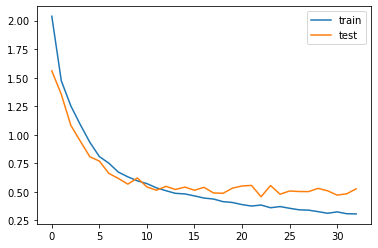

In [17]:
# visualize and understand the performance of the model over a period of time
from matplotlib import pyplot 
pyplot.plot(history.history['loss'], label='train') 
pyplot.plot(history.history['val_loss'], label='test') 
pyplot.legend() 
pyplot.show()

In [18]:
# loading the best model
from keras.models import load_model
model=load_model('best_model.hdf5')

In [19]:
# predict text for the given audio
def predict(audio):
    prob=model.predict(audio.reshape(1,8000,1))
    index=np.argmax(prob[0])
    return classes[index]

In [21]:
# Make predictions on validation data
import random
index=random.randint(0,len(x_val)-1)
samples=x_val[index].ravel()
print("Audio:",classes[np.argmax(y_val[index])])
ipd.Audio(samples, rate=8000)
print("Text:",predict(samples))

Audio: left
Text: left


# a script that prompts a user to record voice commands

In [37]:
import sounddevice as sd
import soundfile as sf

samplerate = 16000  
duration = 1 # seconds
filename = 'yes.wav'
print("start")
mydata = sd.rec(int(samplerate * duration), samplerate=samplerate,
    channels=1, blocking=True)
print("end")
sd.wait()
sf.write(filename, mydata, samplerate)

start
end


In [38]:
# now read the saved voice command and convert it to text

os.listdir('input')
filepath='input'

#reading the voice commands
samples, sample_rate = librosa.load(filepath + '/' + 'yes.wav', sr = 16000)
samples = librosa.resample(samples, sample_rate, 8000)
ipd.Audio(samples,rate=8000)  

predict(samples)

'yes'